### Part 1: Implement STDP with Brian2 simulator & then implement STDP manual simulation. Compare the results by showing plots with synapse weight membrane potential activation and spiking, weight distribution scatter plot, histogram for weight distribution and weight change over time.

In [1]:
# First let's simulate STDP with Brian2 library
!pip install brian2

In [2]:
# Simulate 1 second with 1000 connected randomly distributed spiked synapses
from brian2 import *

N = 1000
taum = 10*ms
taupre = 20*ms
taupost = taupre
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 10*Hz
gmax = .015
dApre = .005
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

eqs_neurons = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

poisson_input = PoissonGroup(N, rates=F)
neurons = NeuronGroup(1, eqs_neurons, threshold='v>vt', reset='v = vr',
                      method='euler')
S = Synapses(poisson_input, neurons,
             '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''',
             )
S.connect()
S.w = 'rand() * gmax'
mon = StateMonitor(S, 'w', record=[0, 1])
mon2 = StateMonitor(S, 'Apost', record=[0, 1])
mon3 = StateMonitor(S, 'Apre', record=[0, 1])
m = StateMonitor(neurons, 'v', record=0)
spike_monitor = SpikeMonitor(poisson_input)
s_mon = SpikeMonitor(poisson_input)

run(50*second, report='text')

Starting simulation at t=0. s for a duration of 50. s
36.1387 s (72%) simulated in 10s, estimated 4s remaining.
50. s (100%) simulated in 13s


#### Plot neuron spikes, Synaptic weight, Excitatory synaptic conductance, post-synaptic trace, pre-synaptic trace from brian2

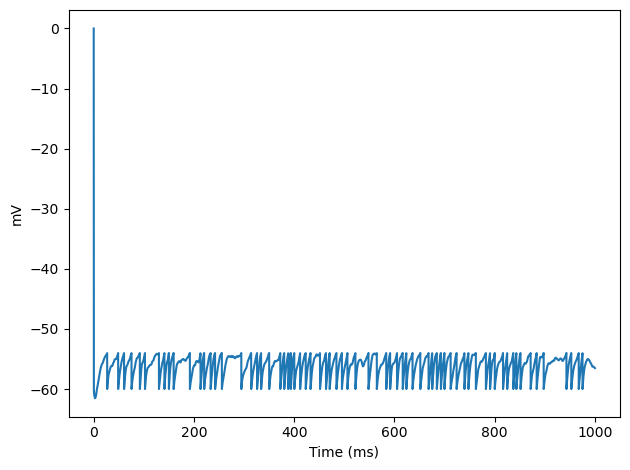

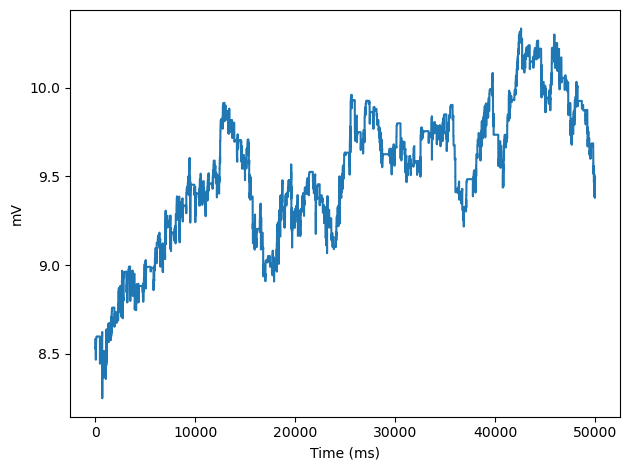

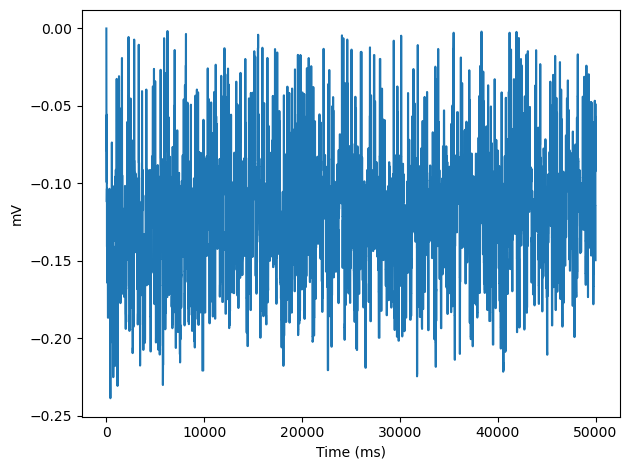

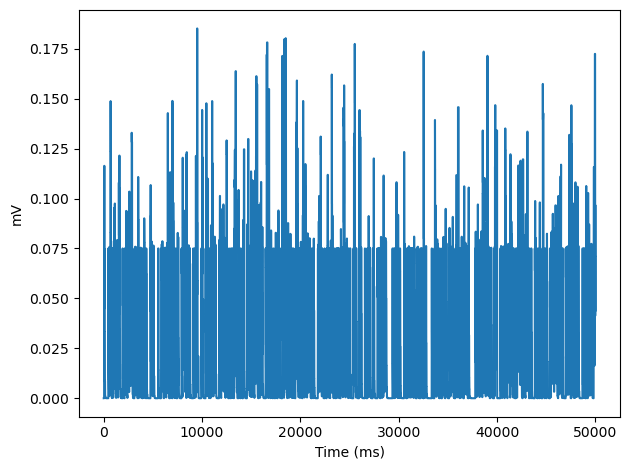

In [3]:
plot(m.t[0:10000]/ms, m.v[0][0:10000]/ms)
xlabel('Time (ms)')
ylabel('mV')
tight_layout()
show()

plot(m.t/ms, mon.w[0]/ms)
xlabel('Time (ms)')
ylabel('mV')
tight_layout()
show()

plot(m.t/ms, mon2.Apost[0]/ms)
xlabel('Time (ms)')
ylabel('mV')
tight_layout()
show()

plot(m.t/ms, mon3.Apre[0]/ms)
xlabel('Time (ms)')
ylabel('mV')
tight_layout()
show()

#### Implement STDP Manually by using trace variables

In [20]:
# Now implement STDP manually and plot the spikes
import numpy as np
import matplotlib.pyplot as plt
import random

def runSTDPSim(inputFrequency=10, dApre=.005, El=-74, gmax=.015, timesteps = 10000.0, dApredApostFactor=1.05, synapticInput=None, areRandomSynapse=True):
  # Time parameters
  T = timesteps      # total time to simulate (ms)
  dt = 0.1     # simulation time step (ms)
  time = np.arange(0, T, dt)
  vr = -60


  # Neuron parameters
  # El = -74      # Resting membrane potential (mV)
  Ee = 0        # Excitatory reversal potential (mV)
  taue = 5      # Excitatory synaptic time constant (ms)
  taum = 10     # Membrane time constant (ms)

  # Initial conditions
  initialV = 0        # Membrane potential initialized to resting potential
  initialGe = 0.0      # Initial synaptic conductance

  Vth = -54     # Spike threshold (mV)
  taupre = 20
  taupost = taupre

  dApost = -dApre * taupre / taupost * dApredApostFactor
  dApost *= gmax
  dApre *= gmax
  
  ratio_inh_to_exc = []
  spike_times = []

  # Define 1 neuron
  refractory_period_ms_neuron = 5
  neuron = { 'V': initialV, 'ge': initialGe, 'V_trace': [], 'ge_trace': [] }

  # Define simulated neuron stimulations for this inputs
  simulatedInputNr = 1000
  rate_hz = inputFrequency
  
  if synapticInput is not None:
    all_activations = synapticInput
  else:
    lambda_per_millisecond = rate_hz / 1000
    lambda_per_timestep = lambda_per_millisecond * dt
    all_activations = np.zeros((simulatedInputNr, len(time)))

    for i in range(simulatedInputNr):
      activations_2d = np.random.poisson(lambda_per_timestep, len(time))
      binary_activations_2d = np.where(activations_2d > 0, 1, 0)
      all_activations[i] = binary_activations_2d
      
  if areRandomSynapse:
    w_init = np.random.rand(simulatedInputNr) * gmax
    w_init_return = w_init.copy()
  else:
    w_init = np.full(simulatedInputNr, 0.2 * gmax)
    w_init_return = w_init.copy()

  synapse = { 'input': all_activations,
            'to_neuron': neuron,
              'Apre': np.zeros(simulatedInputNr),
              'Apost': np.zeros(simulatedInputNr),
              'w': w_init
            }
  neuronSpiked = False
  w_trace = np.zeros((simulatedInputNr, len(time)))  # Initialize a 2D array to store weights over time
  Apost_trace = np.zeros((simulatedInputNr, len(time)))
  Apre_trace = np.zeros((simulatedInputNr, len(time)))
  peak_synaptic_conductance = np.zeros(simulatedInputNr)

  # Simulation
  for i, t in enumerate(time):
    neuron['V_trace'].append(neuron['V'])
    neuron['ge_trace'].append(neuron['ge'])
    # STDP synapse part
    # get current inputs
    currentInputs = synapse['input'][:, i]
    
    for j in range(simulatedInputNr):
      if neuronSpiked:
        synapse['Apost'][j] += dApost
        synapse['w'][j] = np.clip(synapse['w'][j] + synapse['Apre'][j], 0, gmax)
        
      elif currentInputs[j] == 1:
        synapse['Apre'][j] += dApre
        synapse['w'][j] = np.clip(synapse['w'][j] + synapse['Apost'][j], 0, gmax)
        neuron['ge'] += synapse['w'][j]
      else:
        synapse['Apre'][j] -= (synapse['Apre'][j] / taupre) * dt
        synapse['Apost'][j] -= (synapse['Apost'][j] / taupost) * dt
        
      if synapse['w'][j] > peak_synaptic_conductance[j]:
          peak_synaptic_conductance[j] = synapse['w'][j]
        
    neuronSpiked = False

    w_trace[:, i] = synapse['w']
    Apost_trace[:, i] = synapse['Apost']
    Apre_trace[:, i] = synapse['Apre']
    
    # Check if we are in the refractory period
    # if t - last_spike_time < refractory_period_ms_neuron:
    #     continue  # Skip the rest of the loop if we are in the refractory period

    # neuron part
    dVdt = (neuron['ge'] * (Ee - neuron['V']) + (El - neuron['V'])) / taum
    neuron['V'] += dt * dVdt
    neuron['ge'] += dt * (-neuron['ge']) / taue

    # Check for spikes
    if neuron['V'] >= Vth:
      neuron['V'] = vr
      neuronSpiked = True
      spike_times.append(t)
      last_spike_time = t
    
  total_spikes = len(spike_times)
  post_synaptic_firing_rate = total_spikes / (T / 1000)
  return time, neuron, synapse, w_trace, gmax, simulatedInputNr, post_synaptic_firing_rate, spike_times, all_activations, Apost_trace, Apre_trace, peak_synaptic_conductance, w_init_return

time, neuron, synapse, w_trace, gmax, simulatedInputNr, _, _, all_activations, Apost_trace, Apre_trace, _, _ = runSTDPSim(10, timesteps=50000)

#### Plot neuron spikes, Synaptic weight, Excitatory synaptic conductance, post-synaptic trace, pre-synaptic trace from the manual implementation

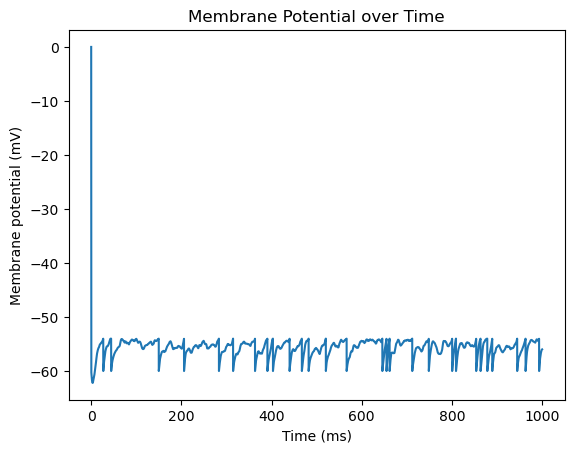

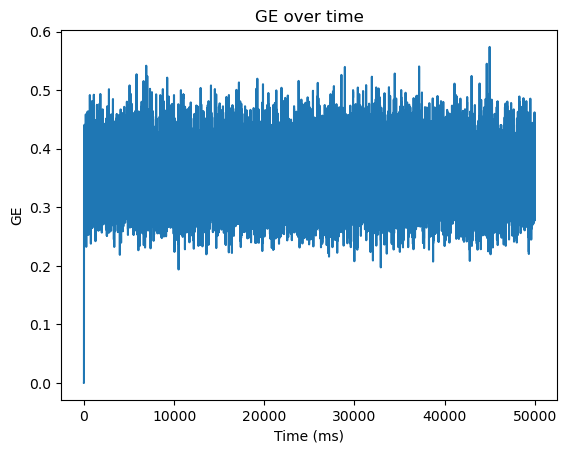

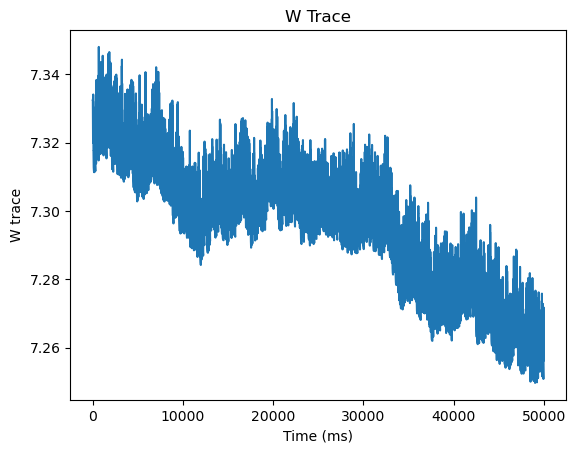

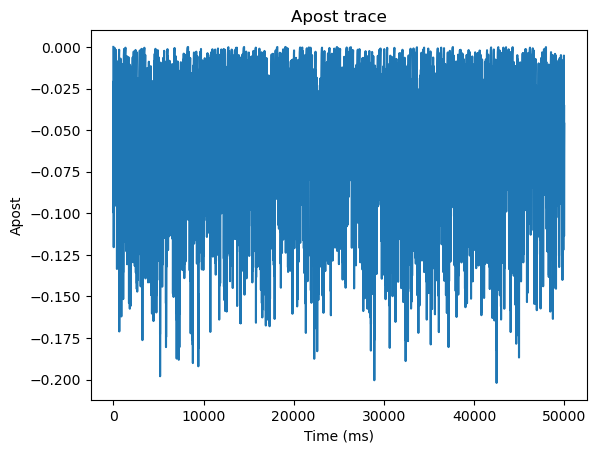

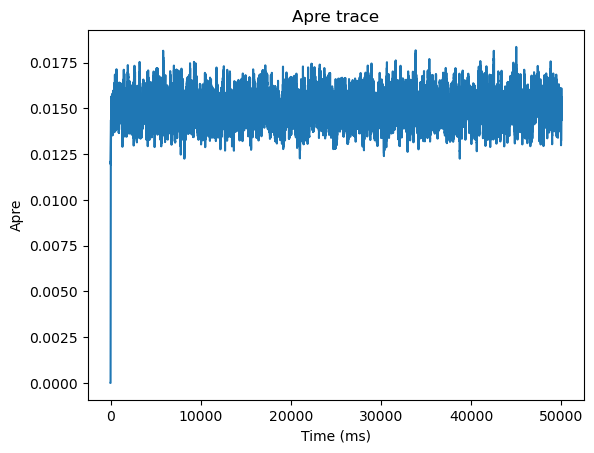

In [11]:
plt.plot(time[0:10000], neuron['V_trace'][0:10000])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane Potential over Time')
plt.show()

plt.plot(time, neuron['ge_trace'])
plt.xlabel('Time (ms)')
plt.ylabel('GE')
plt.title('GE over time')
plt.show()

plt.plot(time, np.sum(w_trace, axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('W trace')
plt.title('W Trace')
plt.show()

plt.plot(time, np.sum(Apost_trace, axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Apost')
plt.title('Apost trace')
plt.show()

plt.plot(time, np.sum(Apre_trace, axis=0))
plt.xlabel('Time (ms)')
plt.ylabel('Apre')
plt.title('Apre trace')
plt.show()

#### Plot the brian2 weights distribution and then weights distribution from manually imeplemented STDP

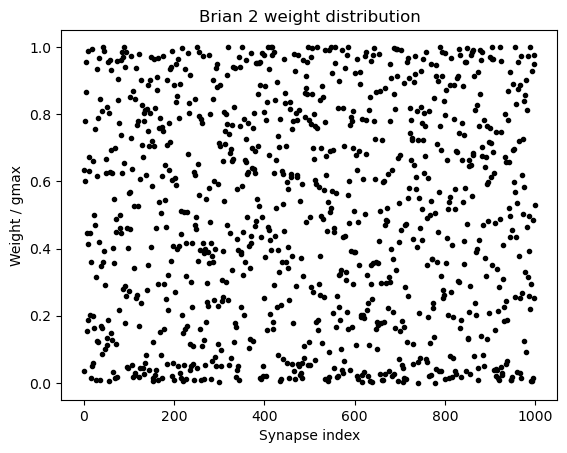

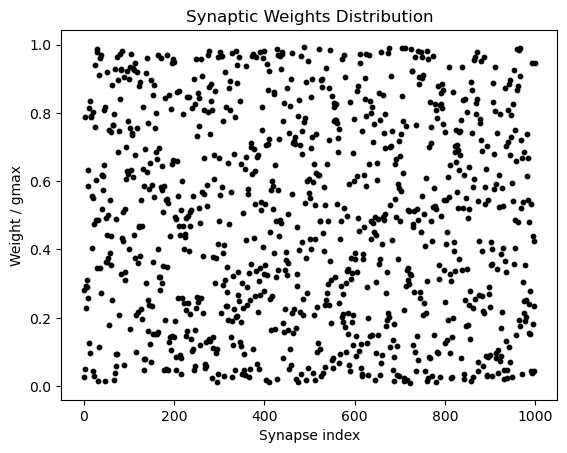

In [12]:

# Brian 2
figure()
title('Brian 2 weight distribution')
plot(S.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
show()

all_traces = np.sum(w_trace, axis=1) / len(time)
# # Manual STDP
figure()
plt.scatter(range(all_traces.size), all_traces / gmax, s=10, c='k')
plt.xlabel('Synapse index')
plt.ylabel('Weight / gmax')
plt.title('Synaptic Weights Distribution')
show()

#### Plot histogram of weights (brian2/manual)

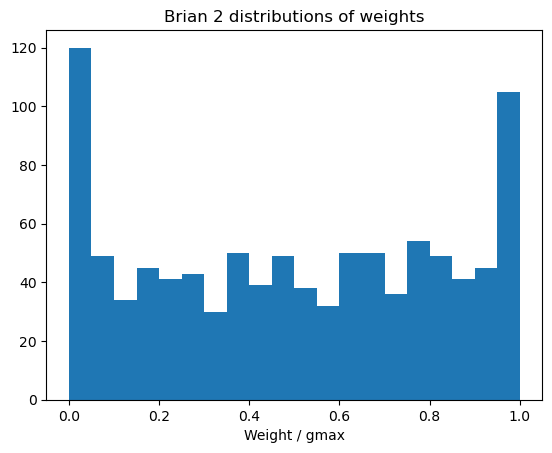

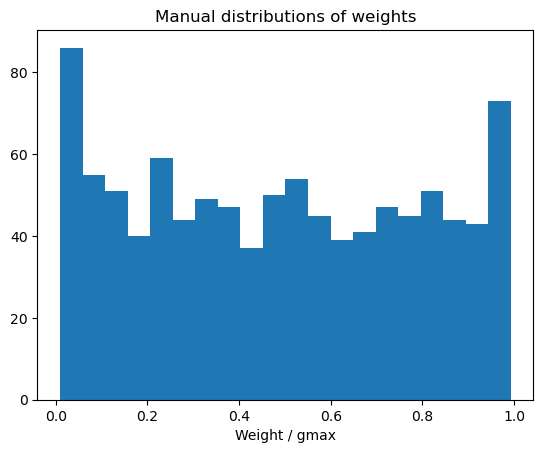

In [13]:
# First brian2
figure()
hist(S.w / gmax, 20)
title('Brian 2 distributions of weights')
xlabel('Weight / gmax')
show()

#Now manual
figure()
hist((np.sum(w_trace, axis=1) / len(time)) / gmax, 20)
title('Manual distributions of weights')
xlabel('Weight / gmax')
show()

#### Plot evolution of weights for the first and second synaptic weight (brian2/manual)

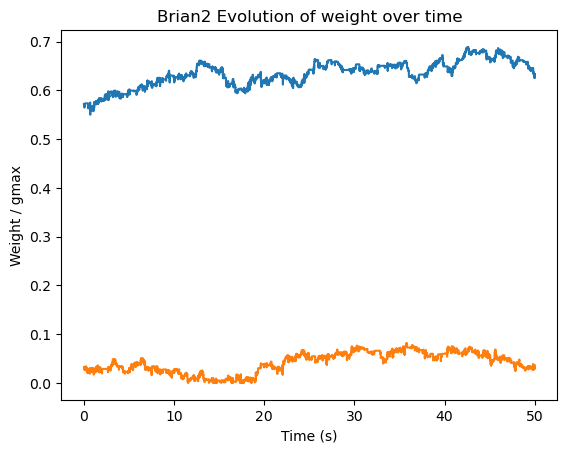

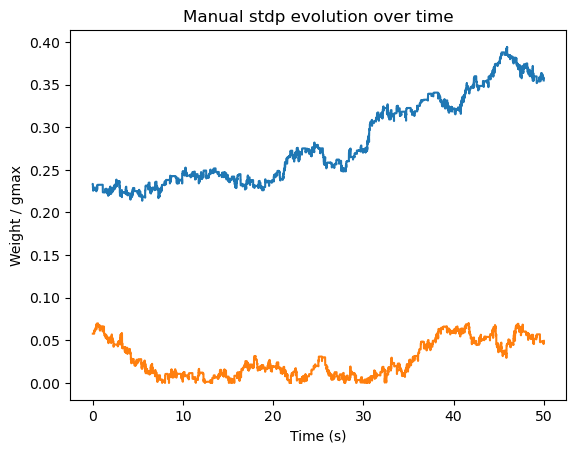

In [14]:
figure()
title('Brian2 Evolution of weight over time')
plot(mon.t/second, mon.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
show()

figure()
title('Manual stdp evolution over time')
plot(time/1000, w_trace[0, :]/gmax)
plot(time/1000, w_trace[1, :]/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
show()

### Part 2: Reproduce compeptition and latency reduction results from Song et al. (2000) "Competitive Hebbian learning through spike-timing-dependent synaptic plasticity"

##### First: Plot 2 histograms, one at 10hz input frequency and the other at 40hz. The histograms represent the fraction of synapses taking different peak conductance values ranging from 0 to gmax.

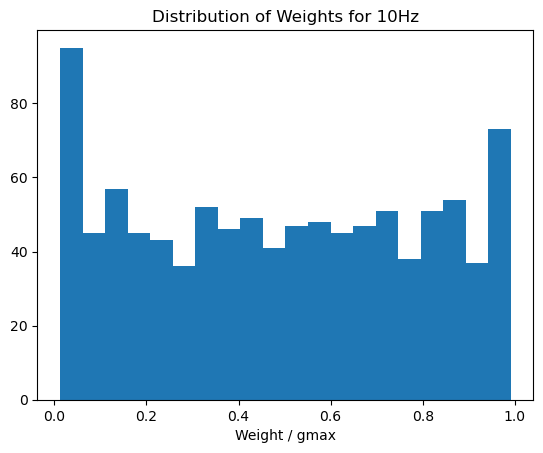

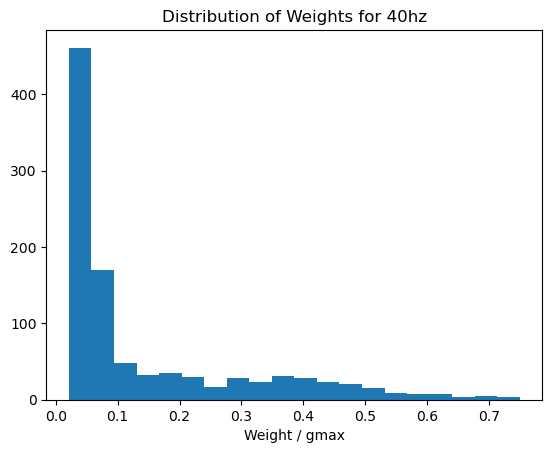

In [459]:
time, neuron10hz, synapse10hz, w_trace10hz, gmax, _, _, _, _, _, _, _, _ = runSTDPSim(10)
_, neuron40hz, synapse40hz, w_trace40hz, _, _, _, _, _, _, _, _, _ = runSTDPSim(40)

# Plot the histogram
plt.figure()
hist((np.sum(w_trace10hz, axis=1) / len(time)) / gmax, 20)
plt.title('Distribution of Weights for 10Hz')
plt.xlabel('Weight / gmax')
plt.show()

plt.figure()
hist((np.sum(w_trace40hz, axis=1) / len(time)) / gmax, 20)
plt.title('Distribution of Weights for 40hz')
plt.xlabel('Weight / gmax')
plt.show()

We can notice above that for an input rate of:
- 10hz: The peak synaptic conductances tend to the limiting values, more towards gmax than near 0.
- 40hz: More peak conductances are near 0 than near gmax.

#### Plot figure regarding the number of strong synapses for different input frequencies (10-40 Hz).

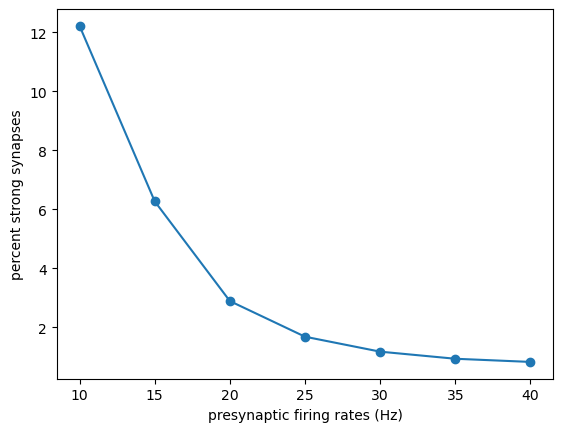

In [8]:
strong_synapses_range = linspace(10, 40, 7)
strong_synapses_perc = np.zeros(len(strong_synapses_range))
inh_to_exc = []
threshold = 0.8
gmax = 0.035
for i, currentHz in enumerate(strong_synapses_range):
    time, currNeuron, currSynapse, w_trace, gmax, _, _, _, _, _, _, _, _ = runSTDPSim(currentHz, gmax=gmax, timesteps = 10000)
    all_synapses_weights = np.concatenate(w_trace)
    strong_synapses_count = np.sum(all_synapses_weights >= (threshold * gmax))
    percentage_strong_synapses = strong_synapses_count / all_synapses_weights.size * 100
    strong_synapses_perc[i] = percentage_strong_synapses

plt.figure()
plt.plot(strong_synapses_range, strong_synapses_perc, 'o-', label='percent strong synapses')
plt.ylabel('percent strong synapses')
plt.xlabel('presynaptic firing rates (Hz)')
plt.show()

#### Plot figure regarding Postsynaptic firing rate in Hz given different values of presynaptic firing rate

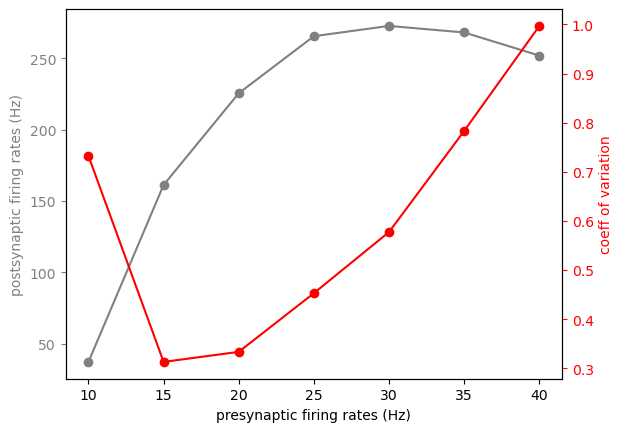

In [9]:
firing_range = linspace(10, 40, 7)
firing_range_postsynaptic = np.zeros(len(firing_range))
cvs = np.zeros(len(firing_range))

for i, currentHz in enumerate(firing_range):
    time, currNeuron, currSynapse, w_trace, gmax, _, post_synaptic_firing_rate, spike_times, _, _, _, _, _ = runSTDPSim(currentHz, timesteps=10000)
    firing_range_postsynaptic[i] = post_synaptic_firing_rate
    
    spike_times = np.array(spike_times)
    interspike_intervals = np.diff(spike_times)
    mean_isi = np.mean(interspike_intervals)
    std_isi = np.std(interspike_intervals)
    cv = std_isi / mean_isi
    
    cvs[i] = (cv)
    
fig, ax1 = plt.subplots()
plt.xlabel('presynaptic firing rates (Hz)')
ax1.plot(firing_range, firing_range_postsynaptic, 'o-', color='gray', label='presynaptic firing rates (Hz)')
ax1.set_ylabel('postsynaptic firing rates (Hz)', color='grey')
ax1.tick_params('y', colors='grey')

ax2 = ax1.twinx()
ax2.plot(firing_range, cvs, 'o-', color='red', label='coeff of variation')
ax2.set_xlabel('presynaptic firing rates (Hz)')
ax2.set_ylabel('coeff of variation', color='red')
ax2.tick_params('y', colors='red')

plt.show()


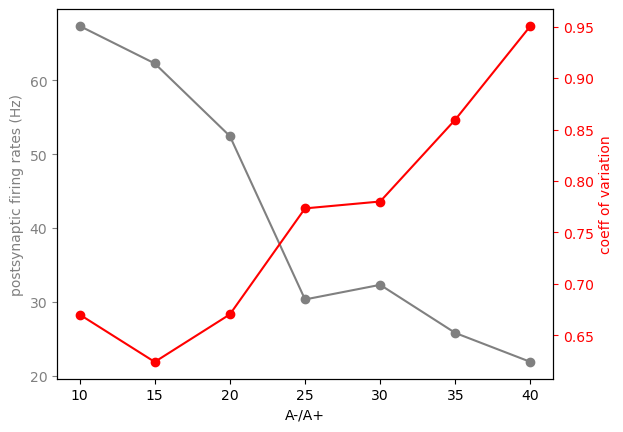

In [13]:
dApredApostFactorSpace = linspace(1, 1.10, 7)
firing_range_postsynaptic = np.zeros(len(firing_range))
cvs = np.zeros(len(firing_range))

for i, currdApredApostFactor in enumerate(dApredApostFactorSpace):
    time, currNeuron, currSynapse, w_trace, gmax, _, post_synaptic_firing_rate, spike_times, _, _, _, _, _ = runSTDPSim(10, timesteps=50000, dApredApostFactor=currdApredApostFactor)
    firing_range_postsynaptic[i] = post_synaptic_firing_rate
    
    spike_times = np.array(spike_times)
    interspike_intervals = np.diff(spike_times)
    mean_isi = np.mean(interspike_intervals)
    std_isi = np.std(interspike_intervals)
    cv = std_isi / mean_isi
    
    cvs[i] = (cv)
    
fig, ax1 = plt.subplots()
plt.xlabel('A-/A+')
ax1.plot(firing_range, firing_range_postsynaptic, 'o-', color='gray', label='A-/A+')
ax1.set_ylabel('postsynaptic firing rates (Hz)', color='grey')
ax1.tick_params('y', colors='grey')

ax2 = ax1.twinx()
ax2.plot(firing_range, cvs, 'o-', color='red', label='coeff of variation')
ax2.set_xlabel('presynaptic firing rates (Hz)')
ax2.set_ylabel('coeff of variation', color='red')
ax2.tick_params('y', colors='red')

plt.show()


### Part 3: Reduction of latency by STDP. We are going to model waves of excitatory input to the synapse and plot figures regarding:
##### 1. The waves of activations following a normal distribution.
##### 2. Peak synaptic conductances as a function of relative latency before and after STDP settles.
##### 3. Postsynaptic membrane potential at waves of activations before and after STDP settles.

580.0


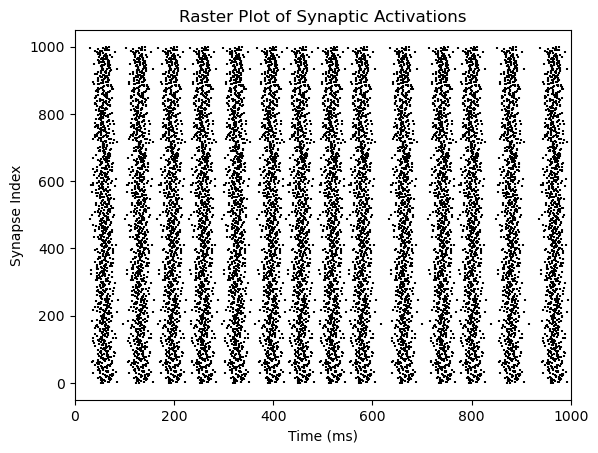

In [70]:


def createBurstedSimulatedInput(T=10000, dt=0.1, burst_duration_ms=20, gaussian_mean=0, gaussian_sd=10, burst_rate_hz=15, simulatedInputNr=1000):
    time = np.arange(0, T, dt)
    all_activations = np.zeros((simulatedInputNr, len(time)))
    
    # Generate a single set of burst start times for all synapses using a Poisson process
    average_interval = 1000 / burst_rate_hz  # Average interval in ms
    num_bursts = int(T / average_interval)
    burst_starts = np.cumsum(np.random.poisson(average_interval, num_bursts)) / dt  # Convert to time steps
    relative_latency = np.zeros(simulatedInputNr)
    relative_delay = np.zeros(simulatedInputNr)
    for i in range(simulatedInputNr):
        relative_delay[i] = np.random.normal(gaussian_mean, gaussian_sd) / dt
        relative_latency[i] = relative_delay[i]
        
    first_burst_mean = 0
    last_burst_mean = 0
    currJ = 0
    
    # Within each burst, apply Gaussian-distributed delays to each synapse
    for j, start in enumerate(burst_starts):
        if start < len(time):  # Ensure the burst start is within the simulation time
            for i in range(simulatedInputNr):
                # Gaussian-distributed delay for each synapse activation within a burst
                curr_delay = relative_delay[i]
                end = start + burst_duration_ms
                mean_time = ((start + end) / 2) + curr_delay
                spike_index = int(mean_time)
                
                if spike_index < len(time):
                    if j == 0 and first_burst_mean == 0:
                        print(start)
                        first_burst_mean = int((start + end) / 2)
                    if j > currJ:
                        last_burst_mean = int((start + end) / 2)
                    all_activations[i, spike_index]= 1
                    
    return all_activations, relative_latency, first_burst_mean, last_burst_mean

def plot_activations(all_activations, dt, T, first_burst_mean = None):
    num_synapses, num_time_steps = all_activations.shape
    end_time = T

    # Create a raster plot
    fig, ax = plt.subplots()
    for i in range(num_synapses):
        spike_indices = np.where(all_activations[i, :] == 1)[0]
        spike_times = spike_indices * dt
        ax.scatter(spike_times, np.ones_like(spike_times) * i, marker='|', color='black', s=1)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Synapse Index')
    ax.set_title('Raster Plot of Synaptic Activations')
    ax.set_xlim(20, 100)

    # Explicitly set the x-axis to cover the full simulation range
    if first_burst_mean is not None:
        ax.set_xlim(first_burst_mean - 40, first_burst_mean + 40)
    else:
        ax.set_xlim(0, min(T, 1000))
    plt.show()

T = 10000
dt = 0.1

# Assuming 'all_activations' and 'dt' are defined from the previous function call
burstedInputs, relative_latency, first_burst_mean, last_burst_mean = createBurstedSimulatedInput(T)
first_burst_mean = first_burst_mean * dt
last_burst_mean = last_burst_mean * dt
plot_activations(burstedInputs, dt, T)

time, currNeuron, currSynapse, w_trace, gmax, _, post_synaptic_firing_rate, spike_times, _, _, _, peak_w, w_init = runSTDPSim(10, timesteps=10000, gmax=0.02, areRandomSynapse=False, synapticInput=burstedInputs)


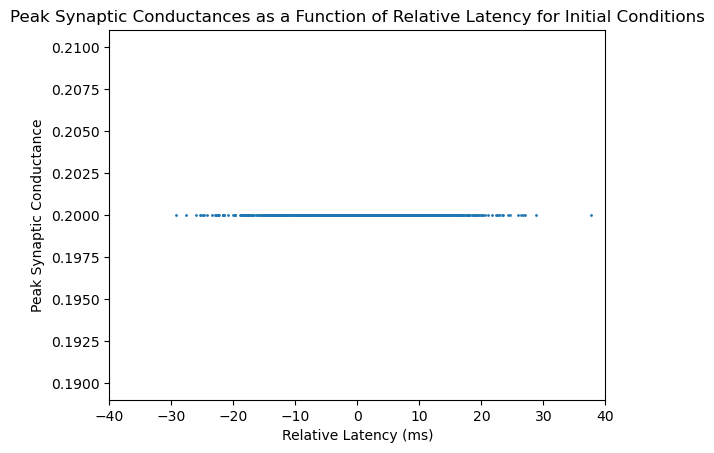

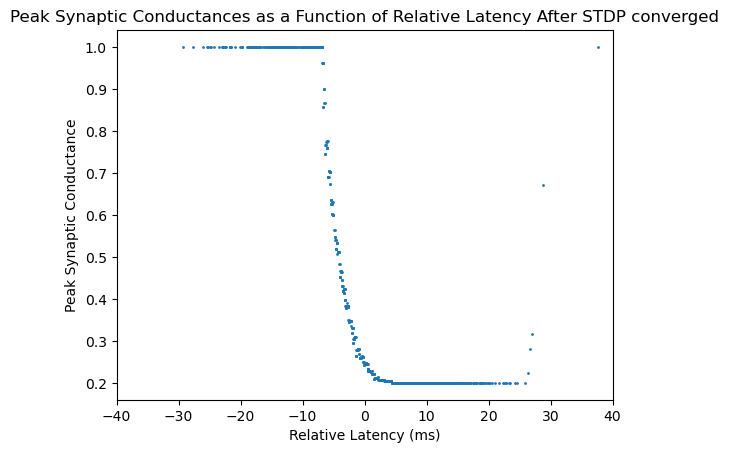

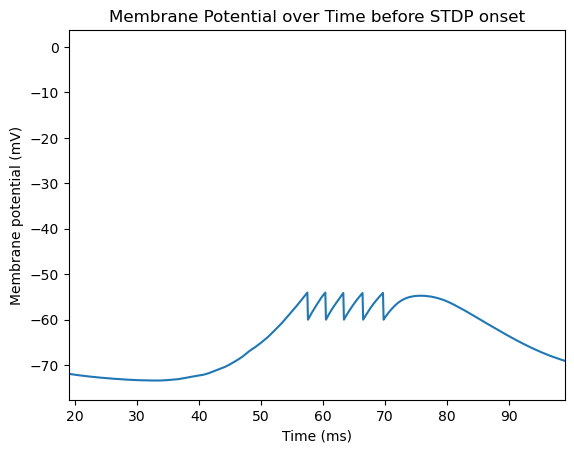

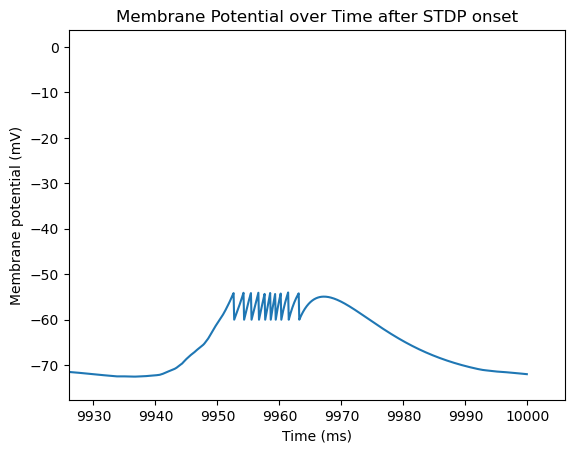

In [72]:
fig, ax = plt.subplots()
ax.scatter(relative_latency * dt, w_init / gmax, s=1)
ax.set_xlabel('Relative Latency (ms)')
ax.set_ylabel('Peak Synaptic Conductance')
ax.set_xlim(-40, 40)
ax.set_title('Peak Synaptic Conductances as a Function of Relative Latency for Initial Conditions')
plt.show()

fig, ax = plt.subplots()
ax.scatter(relative_latency * dt, peak_w / gmax, s=1)
ax.set_xlabel('Relative Latency (ms)')
ax.set_ylabel('Peak Synaptic Conductance')
ax.set_xlim(-40, 40)
ax.set_title('Peak Synaptic Conductances as a Function of Relative Latency After STDP converged')
plt.show()

index1_first_burst = int(first_burst_mean-40)
index2_first_burst = int(first_burst_mean+40)
# First plot the postsynaptic response to the first wave of excitation, before STDP was established
plt.plot(time, currNeuron['V_trace'])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane Potential over Time before STDP onset')
ax = plt.gca()
ax.set_xlim([index1_first_burst, index2_first_burst])
plt.show()

index1_first_burst = int(last_burst_mean-40)
index2_first_burst = int(last_burst_mean+40)
# Second plot the postsynaptic response to the last wave of excitation, after STDP was established
plt.plot(time, currNeuron['V_trace'])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane Potential over Time after STDP onset')
ax = plt.gca()
ax.set_xlim([index1_first_burst, index2_first_burst])
plt.show()

With short-latency inputs strengthened and long-latency inputs weakened, there is a quicker response in postsynaptic neuron firing.